## Imports and Helper Functions

In [1]:
import sys
#Path to Trane for imports
sys.path.append('/Users/arcarter/code/Trane/Trane-Demos')
path_to_datasets = '../../traneyelpdataset/'
import pandas as pd
import trane
import json
import random
import datetime
import pickle
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.metrics import accuracy_score
from sklearn import metrics
import scikitplot as skplt

def save_obj(obj, name):
    with open('../pickled_objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    try:
        with open('../pickled_objects/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)
    except:
        return None
def generate_probs(entity_id_column,
                            label_generating_column,
                            time_column,
                            table_meta,
                            filter_column,
                            is_pick_random_problems = True):
    generator = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
    probs = []

    all_probs = list(generator.generate())

    if is_pick_random_problems:
        random.shuffle(all_probs)

    for idx, prob in enumerate(all_probs):
        probs.append(prob)
        if idx + 1 == NUM_PROBLEMS_TO_GENERATE:
            break
    prediction_problems_json = trane.prediction_problems_to_json_file(
        probs, table_meta, entity_id_column, label_generating_column, time_column, "prediction_problems.json")

    return probs

def convert(str, format = None):
    return datetime.datetime.strptime(str, format)
def file_to_table_meta(filepath):
    return trane.TableMeta(json.loads(open(filepath).read()))

## Load, Format and Sample Data

In [2]:
filename = 'merged_df'
merged_df = None #load_obj(filename)
if merged_df is None:
    
    yelp_review_df = pd.read_csv(path_to_datasets + 'yelp_review.csv')
    yelp_checkin_df = pd.read_csv(path_to_datasets + 'yelp_checkin.csv')
    yelp_business_df = pd.read_csv(path_to_datasets + 'yelp_business.csv')
    yelp_user_df = pd.read_csv(path_to_datasets + 'yelp_user.csv')

    sampled_yelp_review_df = yelp_review_df.head(1000)
    sampled_business_ids = sampled_yelp_review_df['business_id'].unique()
    sampled_user_ids = sampled_yelp_review_df['user_id'].unique()
    sampled_review_ids = sampled_yelp_review_df['review_id'].unique()
    sampled_yelp_checkin_df = yelp_checkin_df[yelp_checkin_df['business_id'].isin(sampled_business_ids)]
    sampled_yelp_business_df = yelp_business_df[yelp_business_df['business_id'].isin(sampled_business_ids)] 
    sampled_yelp_user_df = yelp_user_df[yelp_user_df['user_id'].isin(sampled_user_ids)]

    assert(len(sampled_business_ids) == len(sampled_yelp_business_df))
    assert(len(sampled_user_ids) == len(sampled_yelp_user_df))
    assert(len(sampled_review_ids) == len(sampled_yelp_review_df))

    print("Sampling Reuslts ---")
    print("Number of reviews: {}".format(len(sampled_yelp_review_df)))
    print("Number of businesses: {}".format(len(sampled_business_ids)))
    print("Number of users: {}".format(len(sampled_user_ids)))
    print("Number of checkins: {}".format(len(sampled_yelp_checkin_df)))

    merge_step_1 = pd.merge(sampled_yelp_review_df, sampled_yelp_user_df, how = 'left', on ='user_id')
    merge_step_2 = pd.merge(merge_step_1, sampled_yelp_business_df, how = 'left', on = 'business_id')
    merge_step_3 = pd.merge(merge_step_2, sampled_yelp_checkin_df, how = 'right', on = 'business_id')
    merged_df = merge_step_3
    merged_df['date'] = merged_df['date'].apply(str)
    merged_df['date'] = merged_df['date'].apply(convert, format = '%Y-%m-%d')
    merged_df = merged_df.rename(columns = {'stars_x': 'stars'})

    distinct_business_ids_in_merged_df = merged_df['business_id'].unique()
    #Note merged_df only contains 959 distinct business_ids. Checkins only contains information from 959 businesses.
    #    That's why merged_df only has 959 distinct business_ids, as opposed to the 974 unique business_ids 
    #    contained in the sample_yelp_review_df.
    #Note merged_df contains more than the 78792 unique check-ins because there are multiple reviews for some business_ids so
    #    each unique review_id is matched to a new business_id. There are 1000 review_ids, but only 974 business_ids.
    #
    save_obj(merged_df, filename)

Sampling Reuslts ---
Number of reviews: 1000
Number of businesses: 974
Number of users: 45
Number of checkins: 78792


## Generate Prediction Problems

In [3]:
table_meta = file_to_table_meta(path_to_datasets + "meta.json")
entity_id_column = 'business_id'
label_generating_column = 'average_stars'
time_column = 'date'
filter_column = 'user_id'
NUM_PROBLEMS_TO_GENERATE = 100

### Note: Code Below Takes 10 Minutes to Execute without Hashing. With Hashing 8 Seconds

In [ ]:
# trane.TableMeta?
# label_generating_column

# table_meta.get_type(label_generating_column)
# table_meta.all_columns

# debugging. stars -> average_stars
# problem_generator_obj = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)

In [4]:
prediction_problems_filename = "../JSON Files/yelp_prediction_problems.json"

problem_generator_obj = trane.PredictionProblemGenerator(table_meta, entity_id_column, label_generating_column, time_column, filter_column)
problem_generator = problem_generator_obj.generator(merged_df)
problems = []
problems = list(problem_generator)

# greaterRowOp = trane.ops.GreaterRowOp(label_generating_column)
# greaterRowOp.set_thresholds(table_meta)

# for prob in probs:
#     prob.operations.append(greaterRowOp)

trane.prediction_problems_to_json_file(problems, table_meta, 
                                       entity_id_column, label_generating_column, 
                                       time_column, 
                                       prediction_problems_filename)


In [ ]:
# debugging
# labeler = trane.Labeler()
# entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
# training_cutoff_time = datetime.date(2012, 1, 1)
# label_cutoff_time = datetime.date(2015, 1, 1)

In [5]:
labeler = trane.Labeler()
entity_to_data_dict = trane.df_group_by_entity_id(merged_df, entity_id_column)
training_cutoff_time = datetime.date(2012, 1, 1)
label_cutoff_time = datetime.date(2015, 1, 1)
#First date: 007-06-12
#Last date: 2017-12-10
entity_to_data_and_cutoff_dict = trane.ConstantCutoffTime(training_cutoff_time, label_cutoff_time).generate_cutoffs(entity_to_data_dict, label_cutoff_time)
labels = labeler.execute(entity_to_data_and_cutoff_dict, prediction_problems_filename)

In [15]:
# write prediction problems
trane.generate_nl_description(problems, table_meta,
                              entity_id_column, label_generating_column,
                              time_column, trane.ConstantCutoffTime(0, 0))


['For each business_id, predict the first average_stars, after date 0.',
 'For each business_id, predict whether the {op} average_stars is greater than 3.63, after date 0.',
 'For each business_id, predict whether the {op} average_stars is equal to 3.72, after date 0.',
 'For each business_id, predict whether the {op} average_stars is not equal to 3.72, after date 0.',
 'For each business_id, predict whether the {op} average_stars is less than 3.72, after date 0.',
 'For each business_id, predict the first the exp of average_stars, after date 0.',
 'For each business_id, predict the first the fluctuation of average_stars, after date 0.',
 'For each business_id, predict the first the fluctuation of the exp of average_stars, after date 0.',
 'For each business_id, predict the firstNone average_stars, after date 0.',
 'For each business_id, predict the firstNone average_stars is greater than 3.63, after date 0.',
 'For each business_id, predict the firstNone average_stars is equal to 3.72

## Deep Feature Synthesis with Feature Tools

In [6]:
# debugging
# training_features_cutoff_times = pd.DataFrame([[_, training_cutoff_time] for _ in sampled_business_ids], columns = ['business_id', 'cutoff_time'])
# training_features_cutoff_times.head(5)

,business_id,cutoff_time
0,AEx2SYEUJmTxVVB18LlCwA,2012-01-01
1,VR6GpWIda3SfvPC-lg9H3w,2012-01-01
2,CKC0-MOWMqoeWf6s-szl8g,2012-01-01
3,ACFtxLv8pGrrxMm6EgjreA,2012-01-01
4,s2I_Ni76bjJNK9yG60iD-Q,2012-01-01


In [4]:
# debugging
# from datetime import date
# from datetime import datetime
# time = training_features_cutoff_times['cutoff_time'].iloc[0]
# isinstance(time, (datetime, date))

NameError: name 'training_features_cutoff_times' is not defined

In [35]:
# debugging
# datetime.date.today()

In [47]:
# debugging
# time

datetime.date(2012, 1, 1)

In [48]:
# debugging
# import importlib
# importlib.reload(ft)
# import featuretools
# importlib.reload(featuretools)
# ft = featuretools

<module 'featuretools' from '/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/featuretools/__init__.py'>

In [7]:
# ft.utils.wrangle._check_time_type('foo')
ft.utils.wrangle.test('foo')

foo


'foo foo'

In [8]:
entities = {
    "business": (sampled_yelp_business_df, "business_id"),
    "reviews": (sampled_yelp_review_df, "review_id"),
    "users": (sampled_yelp_user_df, "user_id"),
    "checkins": (sampled_yelp_checkin_df, "checkin_id")
}
relationships = [
    ("business", "business_id", "reviews", "business_id"),
    ("users", "user_id", "reviews", "user_id"),
    ("business", "business_id", "checkins", "business_id")
]

#----FEATURES FOR TRAINING----#
training_features_cutoff_times = pd.DataFrame([[_, training_cutoff_time] for _ in sampled_business_ids], columns = ['business_id', 'cutoff_time'])

training_features_matrix, training_feature_definitions = ft.dfs(entities = entities,
    relationships = relationships,
    target_entity = "business",
    cutoff_time = training_features_cutoff_times)

training_features_matrix, training_features = ft.encode_features(training_features_matrix, training_feature_definitions)

#----FEATURES FOR TEST----#
test_features_cutoff_times = pd.DataFrame([[_, label_cutoff_time] for _ in sampled_business_ids], columns = ['business_id', 'cutoff_time'])

test_features_matrix, test_feature_definitions = ft.dfs(entities = entities,
    relationships = relationships,
    target_entity = "business",
    cutoff_time = test_features_cutoff_times)
test_features_matrix, test_features = ft.encode_features(test_features_matrix, test_feature_definitions)

2018-05-15 16:32:42,561 featuretools.entityset - WARNING    index checkin_id not found in dataframe, creating new integer column
> /Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/featuretools/utils/wrangle.py(230)_check_time_type()
-> print("hit this")
(Pdb) l
225  	    '''
226  	    Checks if `time` is an instance of common int, float, or datetime types.
227  	    Returns "numeric", "datetime", or "unknown" based on results
228  	    '''
229  	    import pdb; pdb.set_trace()
230  ->	    print("hit this")
231  	    time_type = None
232  	    if isinstance(time, (int, np.int16, np.int32, np.int64, float, np.float16,
233  	                         np.float32, np.float64)):
234  	        time_type = variable_types.NumericTimeIndex
235  	    elif isinstance(time, (date, datetime, np.datetime64)):
(Pdb) n
hit this
> /Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/featuretools/utils/wrangle.py(231)_check_time_type()
-> time_type = None
(Pdb) n
> /Users/arcarter/

## Logistic Regression Fitting and Prediciton





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 0




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 1
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


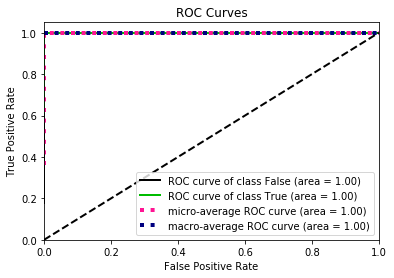





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 2
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


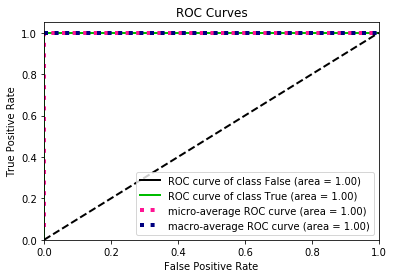





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 3
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


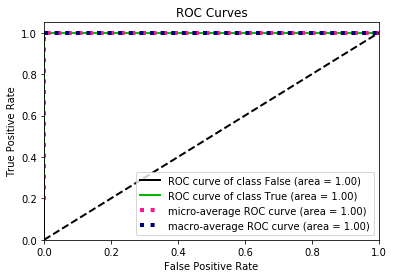





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 4
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


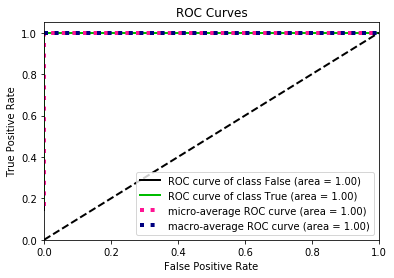





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->IdentityTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 5




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->DiffTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 6




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->DiffTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 7




------------------------------------------------------------------------------------------------

/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


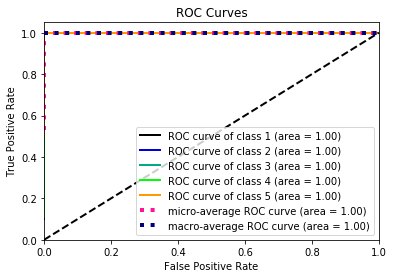





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 9
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


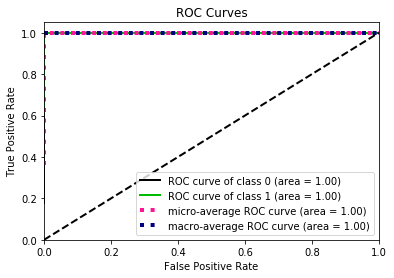





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 10
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


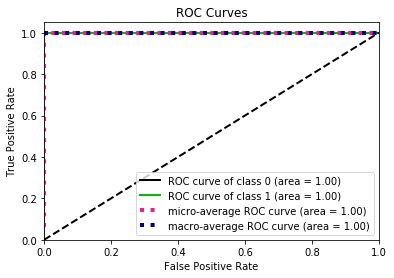





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 11
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


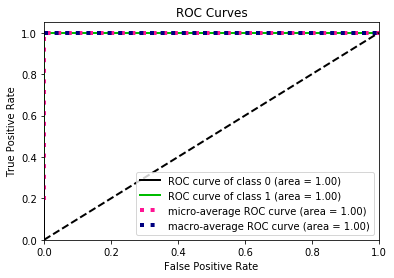





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 12
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


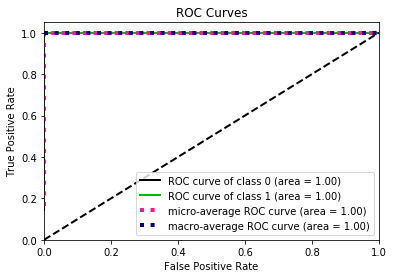





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->FirstAggregationOp(average_stars), idx: 13
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


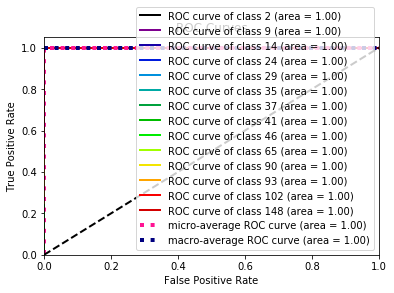





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 14
Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 15


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 16


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 17


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 18


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->IdentityTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 19


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->DiffTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 20


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->DiffTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 21


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9233
Baseline Accuracy Metric: 0.9233, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 22
Classifier Accuracy: 0.9875
Baseline Accuracy Metric: 0.9875, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 23
Classifier Accuracy: 0.9906
Baseline Accuracy Metric: 0.9906, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


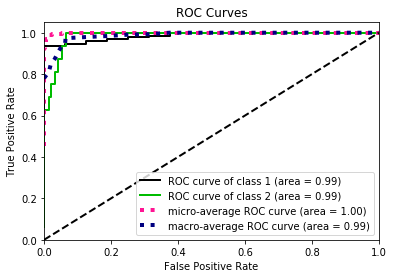





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 24
Classifier Accuracy: 0.9969
Baseline Accuracy Metric: 0.9969, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


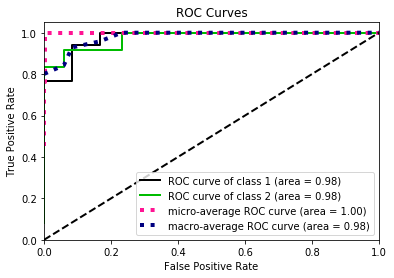





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 25
Classifier Accuracy: 0.9969
Baseline Accuracy Metric: 0.9969, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


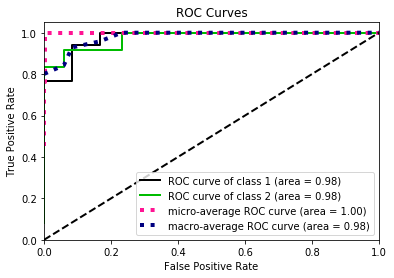





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 26
Classifier Accuracy: 0.9906
Baseline Accuracy Metric: 0.9906, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


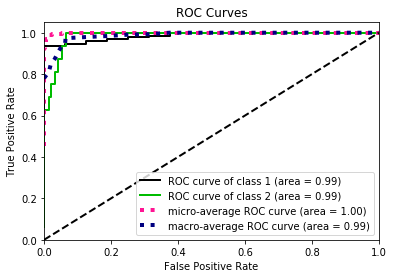





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->CountAggregationOp(average_stars), idx: 27
Classifier Accuracy: 0.9875
Baseline Accuracy Metric: 0.9875, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 28




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregati

/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9844
Baseline Accuracy Metric: 0.9844, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 30


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9937
Baseline Accuracy Metric: 0.9937, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


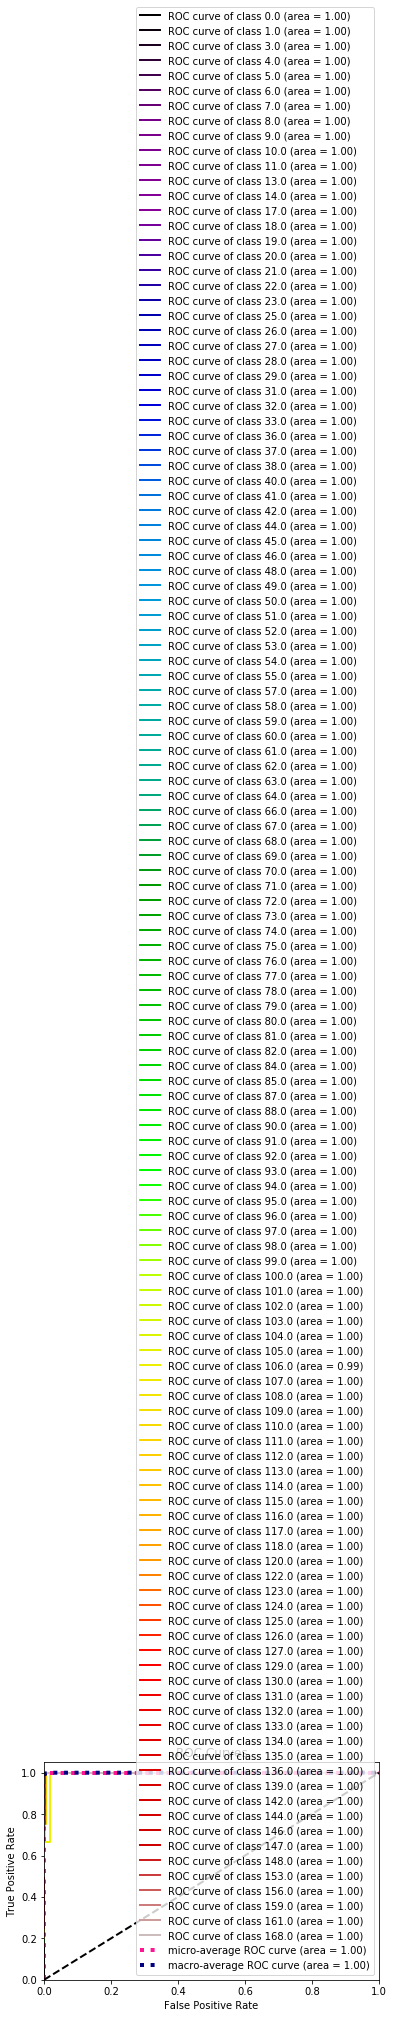





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 31
Classifier Accuracy: 0.9734
Baseline Accuracy Metric: 0.9734, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 32


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9828
Baseline Accuracy Metric: 0.9828, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


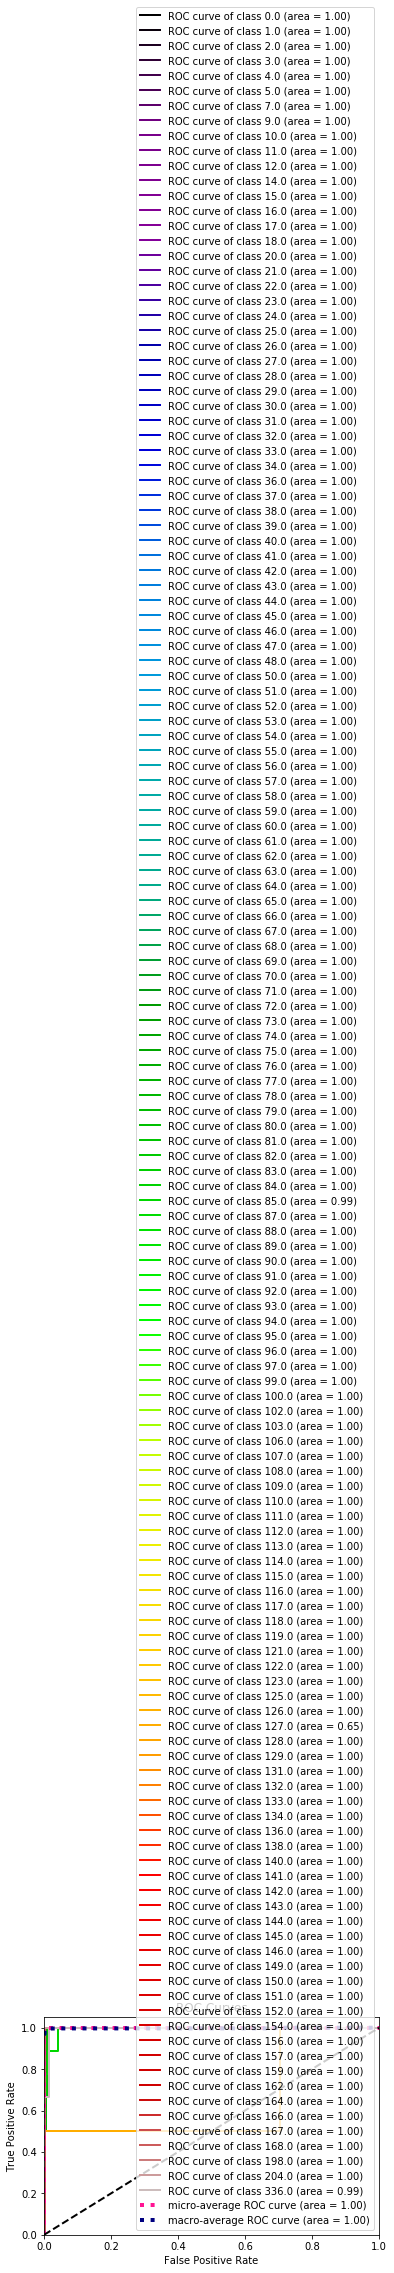





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->IdentityTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 33




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->DiffTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 34




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->DiffTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 35




---------------------------------------------------------------------------------------------------

/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


Classifier Accuracy: 0.9984
Baseline Accuracy Metric: 0.9984, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


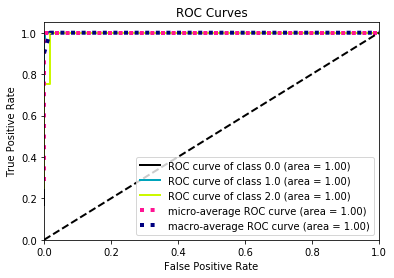





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 38
Classifier Accuracy: 0.9969
Baseline Accuracy Metric: 0.9969, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


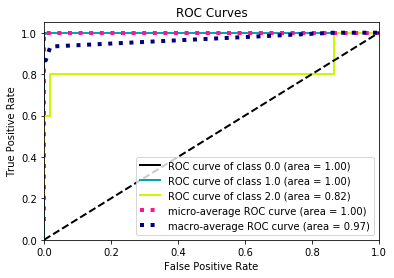





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 39
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


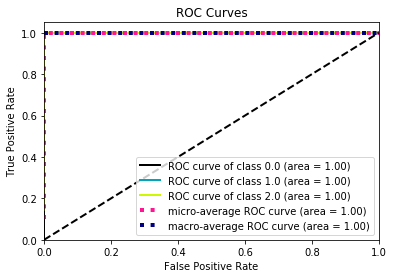





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 40
Classifier Accuracy: 0.9922
Baseline Accuracy Metric: 0.9922, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


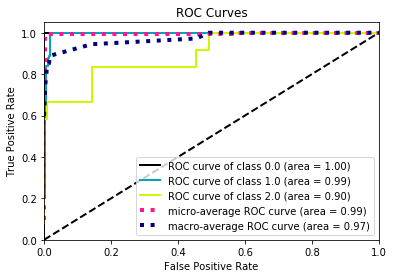





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->SumAggregationOp(average_stars), idx: 41
Classifier Accuracy: 0.9875
Baseline Accuracy Metric: 0.9875, based on using training_labels as the prediction




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 42




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregati

/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


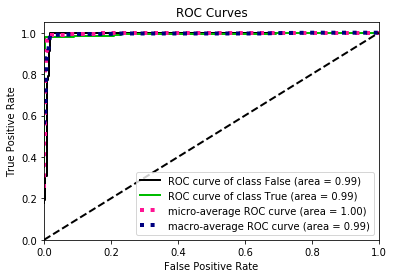





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 44
Classifier Accuracy: 0.9969
Baseline Accuracy Metric: 0.9969, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


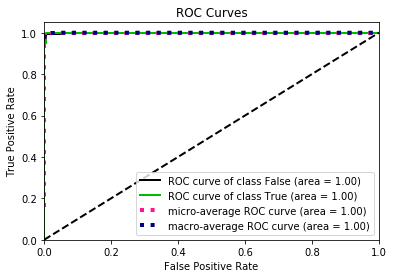





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 45
Classifier Accuracy: 0.9969
Baseline Accuracy Metric: 0.9969, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


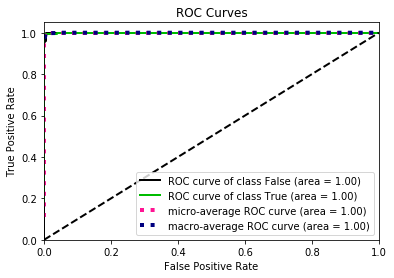





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 46
Classifier Accuracy: 0.9890
Baseline Accuracy Metric: 0.9890, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


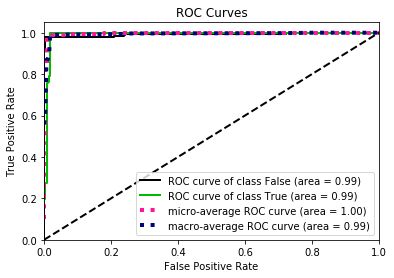





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->IdentityTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 47




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->DiffTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 48




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->DiffTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 49




------------------------------------------------------------------------------------------------

/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


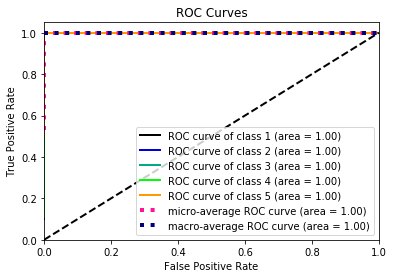





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->GreaterRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 51
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


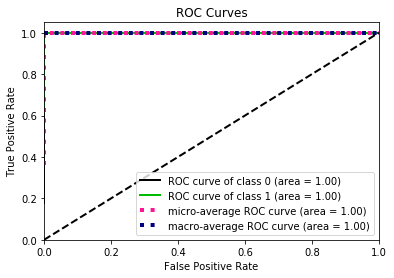





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->EqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 52
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


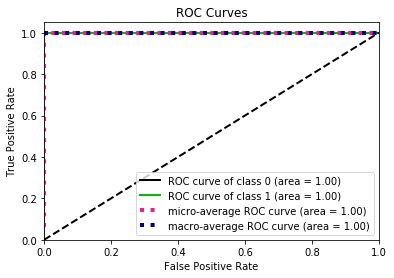





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->NeqRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 53
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


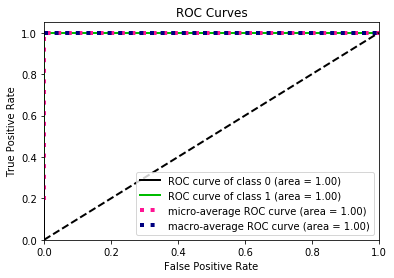





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->LessRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 54
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


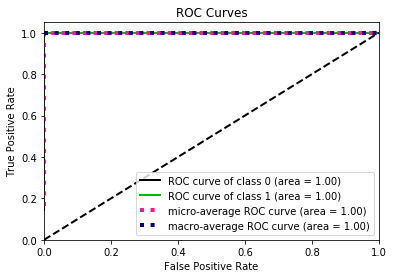





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->ObjectFrequencyTransformationOp(average_stars)->LastAggregationOp(average_stars), idx: 55
Classifier Accuracy: 1.0000
Baseline Accuracy Metric: 1.0000, based on using training_labels as the prediction


/Users/arcarter/.virtualenvs/trane/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


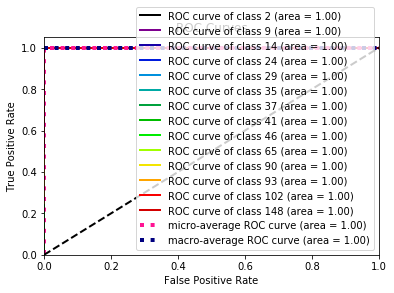





------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->IdentityTransformationOp(average_stars)->LMFAggregationOp(average_stars), idx: 56




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->ExpRowOp(average_stars)->IdentityTransformationOp(average_stars)->LMFAggregationOp(average_stars), idx: 57




------------------------------------------------------------------------------------------------------------------
Training logistic regression on prediction problem: AllFilterOp(user_id)->IdentityRowOp(average_stars)->DiffTransformationOp(average_stars)->LMFAggregationOp(average_stars), idx: 58




------------------------------------------------------------------------------------------

In [9]:
logistic = linear_model.LogisticRegression()

for idx, label in enumerate(labels):
    print('\n\n\n')
    print('------------------------------------------------------------------------------------------------------------------')
    print("Training logistic regression on prediction problem: {}, idx: {}".format(problems[idx], idx))
    label = label.dropna()
    training_features = training_features_matrix[training_features_matrix.index.isin(label.business_id)]
    training_labels = list(label['problem_label_excluding_data_post_label_cutoff_time'])
    
    test_features = test_features_matrix[test_features_matrix.index.isin(label.business_id)]
    test_labels = list(label['problem_label_all_data'])
    try:
        logistic.fit(training_features, training_labels)
    except Exception as e:
#         print("ERROR: {}".format(e))
#         print("label: \n{}".format(label))
        continue
    
    predicted_labels = logistic.predict(test_features)
    predicted_probabilities = logistic.predict_proba(test_features)
    
    accuracy = accuracy_score(test_labels, predicted_labels)
    print("Classifier Accuracy: {0:.4f}".format(accuracy))

    accuracy_no_prediction = accuracy_score(training_labels, predicted_labels)
    print("Baseline Accuracy Metric: {0:.4f}, based on using training_labels as the prediction".format(accuracy))

    try:
        skplt.metrics.plot_roc_curve(test_labels, predicted_probabilities)
    except Exception as e:
#         print("Test labels: {}".format(test_labels['problem_label_excluding_data_post_label_cutoff_time']))
#         print("Predicted probabilities: {}".format(predicted_probabilities))
#         print("ERROR: {}".format(e))
        continue
    plt.show()
